In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [16]:
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [17]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [18]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

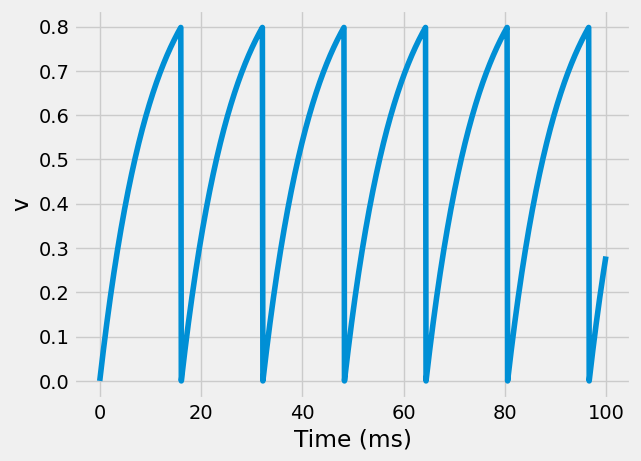

In [19]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

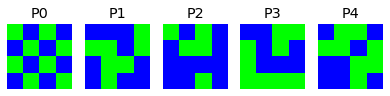

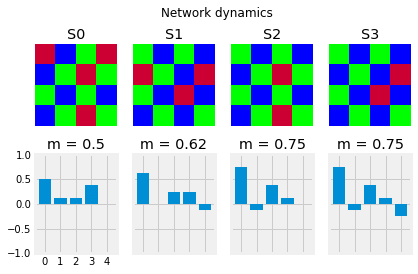

In [18]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

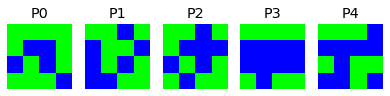

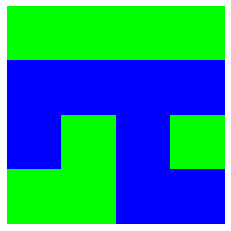

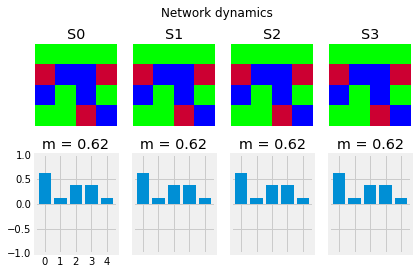

In [40]:
plist = get_patterns(4,5)
#plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)

S = perturb_pattern(cue[0],3)
wghts = calculate_weights(plist, pattern_size)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    state_list.append(network_evolution(S,wghts))
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

# Q1)

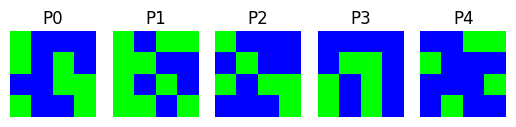

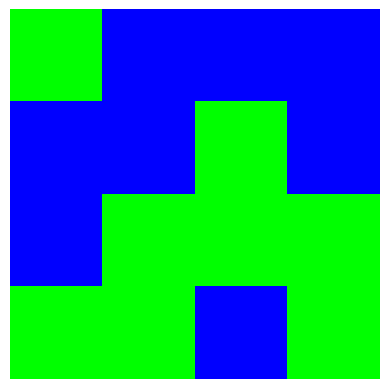

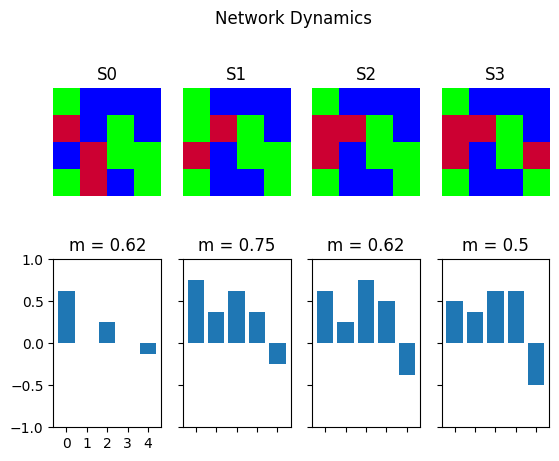

In [13]:
import numpy as np
import copy
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

class HopfieldNet:
    def __init__(self,pt_size):
        self.pt_size = pt_size
        self.num_neuro = pt_size**2
        self.wt = None
        self.pt = []

    def gen_patterns(self, num_pt):
        self.pt = [np.random.choice([-1, 1], size=(self.pt_size, self.pt_size)) for z in range(num_pt)]
        self.compute_weights()

    def compute_weights(self):
        self.wt = np.zeros((self.num_neuro, self.num_neuro))

        for p in self.pt:
            flat_pt = p.flatten()
            self.wt += np.outer(flat_pt, flat_pt)
        
        np.fill_diagonal(self.wt, 0)
        self.wt = self.wt/len(self.pt)

    def perturb(self, pt_index, num_flips):
        pat = self.pt[pt_index].copy()
        flat_index = np.random.choice(self.num_neuro, num_flips, replace=False)
        pat.flat[flat_index] *= -1
        return pat
    
    def update_state(self,state):
        flat_st = state.flatten()
        activation = self.wt @ flat_st
        return np.sign(activation).reshape(state.shape)
    
    def overlap(self, state):
        overlaps = [np.mean(p * state) for p in self.pt]
        return overlaps
    
    def simulation(self,init_state,num_steps):
        state_seq = [init_state]
        for x in range(num_steps):
            nextst = self.update_state(state_seq[-1])
            state_seq.append(nextst)
        return state_seq

def main():
    pattern_size = 4
    num_patterns = 5
    num_flips = 3
    num_steps = 3

    # Generate patterns
    hopfield_net = HopfieldNet(pattern_size)
    hopfield_net.gen_patterns(num_patterns)
    
    # Copy the original patterns for later use as cues
    cue = copy.deepcopy(hopfield_net.pt)

    # Perturb one of the patterns
    S = hopfield_net.perturb(0, num_flips)
    wghts = hopfield_net.wt

    # Initialize the state sequence with the perturbed pattern
    state_list = [S]

    # Evolve the network for a number of steps
    for i in range(num_steps):
        S = hopfield_net.update_state(state_list[-1])
        state_list.append(S)

    # Plotting
    plot_tools.plot_pattern_list(hopfield_net.pt)
    plot_tools.plot_pattern(state_list[0])
    plot_tools.plot_state_sequence_and_overlap(state_list, hopfield_net.pt, reference_idx=0, suptitle="Network Dynamics")

if __name__ == "__main__":
    main()

# Q2)
## A) Informativeness Of Cue

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (6,3)

In [18]:
def compute_accuracy(original, retrieved):
    """
    Calculate the accuracy by comparing the original pattern to the retrieved one.
    """
    correct_matches = np.sum(original == retrieved)
    total_elements = original.size
    return correct_matches / total_elements


### A.1) Variation in number of flips and number of patterns

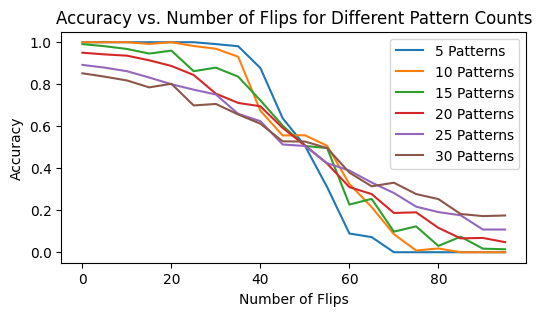

In [28]:
# Analyze the effect of varying the number of patterns and flips on network accuracy
accuracy_results = []

for pattern_count in range(5, 31, 5):
    flip_accuracies = np.zeros(20)
    
    for _ in range(10):  # Repeat for multiple trials
        hopfield_net = HopfieldNet(10)
        hopfield_net.gen_patterns(pattern_count)

        for flip_count in range(0, 96, 5):
            perturbed_state = hopfield_net.perturb(0, flip_count)

            # Evolve the network state multiple times
            for _ in range(5):
                perturbed_state = hopfield_net.update_state(perturbed_state)
            
            # Accumulate accuracy results
            flip_accuracies[flip_count // 5] += compute_accuracy(hopfield_net.pt[0], perturbed_state)

    # Average accuracy over all trials
    accuracy_results.append(flip_accuracies / 10)

# Generate plot of accuracy versus number of flips for varying pattern counts
fig, ax = plt.subplots()

for idx, acc in enumerate(accuracy_results):
    flip_values = np.arange(0, 100, 5)
    ax.plot(flip_values, acc, label=f'{(idx + 1) * 5} Patterns')

ax.set_xlabel('Number of Flips')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Number of Flips for Different Pattern Counts')
ax.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


### A.2) Variation in number of flips and size of patterns

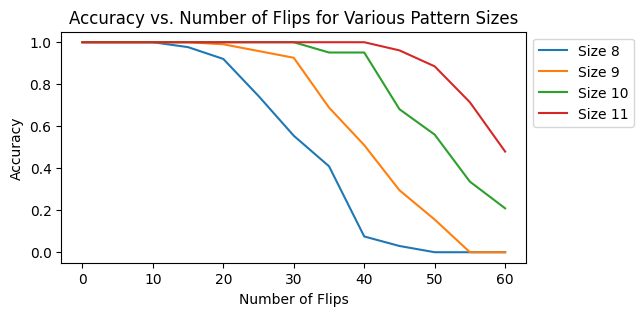

In [33]:
# Evaluate how varying pattern sizes and the number of flips impact network accuracy

accuracy_by_pattern_size = []

for size in range(8, 12):
    accuracy_by_flips = np.zeros(13)
    
    for _ in range(10):  # Perform multiple trials
        network = HopfieldNet(size)
        network.gen_patterns(5)
        weight_matrix = network.wt

        for flip_count in range(0, 61, 5):
            altered_pattern = network.perturb(0, flip_count)
            
            # Iterate to update the state of the pattern
            for _ in range(5):
                altered_pattern = network.update_state(altered_pattern)
            
            # Collect accuracy results for each flip count
            accuracy_by_flips[flip_count // 5] += compute_accuracy(network.pt[0], altered_pattern)
    
    # Average the results for each pattern size
    accuracy_by_pattern_size.append(accuracy_by_flips / 10)

# Plotting accuracy against the number of flips for different pattern sizes

fig, ax = plt.subplots()

for index, accuracy in enumerate(accuracy_by_pattern_size):
    flip_values = np.arange(0, 65, 5)
    ax.plot(flip_values, accuracy, label=f'Size {index + 8}')
    
ax.set_xlabel('Number of Flips')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Number of Flips for Various Pattern Sizes')
ax.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


# B) Number of other patterns stored in network

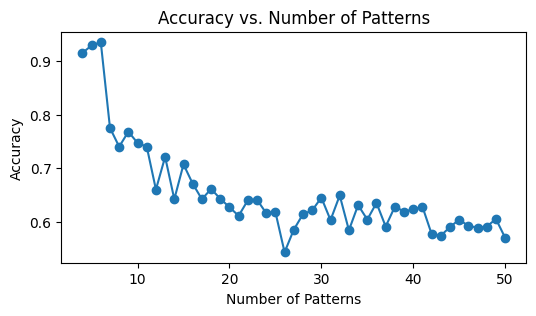

In [34]:
# Examine the effect of varying the number of patterns on accuracy with a fixed number of flips and pattern size

accuracy_by_pattern_count = np.zeros(47)
pattern_range = range(4, 51)

for num_patterns in pattern_range:
    for _ in range(10):
        network = HopfieldNet(10)
        network.gen_patterns(num_patterns)
        initial_patterns = copy.deepcopy(network.pt)
        weight_matrix = network.wt
        
        altered_pattern = network.perturb(0, 40)
        
        # Evolve the pattern over multiple iterations
        for _ in range(5):
            altered_pattern = network.update_state(altered_pattern)
        
        # Update accuracy for the current number of patterns
        accuracy_index = num_patterns - 4
        accuracy_by_pattern_count[accuracy_index] += compute_accuracy(network.pt[0], altered_pattern)

# Average the accuracy results over all trials
average_accuracy = accuracy_by_pattern_count / 10

# Plotting accuracy vs. number of patterns

fig, ax = plt.subplots()

pattern_counts = list(pattern_range)
ax.plot(pattern_counts, average_accuracy, marker='o')

ax.set_xlabel('Number of Patterns')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Number of Patterns')
plt.show()


# C) The size of network

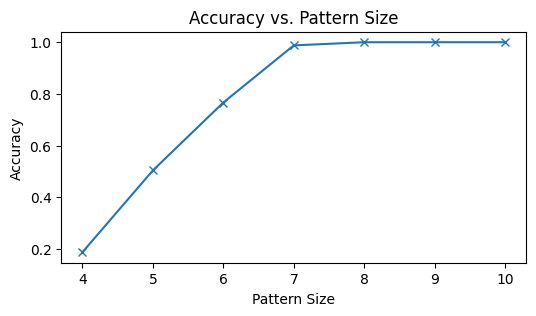

In [35]:
# Explore how varying pattern size affects accuracy with a fixed number of patterns and flips

accuracy_by_pattern_size = np.zeros(7)
pattern_sizes = range(4, 11)

for size in pattern_sizes:
    for _ in range(10):  # Run multiple trials for averaging
        hopfield_network = HopfieldNet(size)
        hopfield_network.gen_patterns(6)
        patterns = copy.deepcopy(hopfield_network.pt)
        weight_matrix = hopfield_network.wt
        
        perturbed_state = hopfield_network.perturb(0, 12)
        
        # Update the state of the perturbed pattern multiple times
        for _ in range(5):
            perturbed_state = hopfield_network.update_state(perturbed_state)
        
        # Accumulate accuracy for the current pattern size
        index = size - 4
        accuracy_by_pattern_size[index] += compute_accuracy(hopfield_network.pt[0], perturbed_state)

# Compute average accuracy over all trials
average_accuracy_by_size = accuracy_by_pattern_size / 10

# Plotting accuracy versus pattern size

fig, ax = plt.subplots()

sizes = list(pattern_sizes)
ax.plot(sizes, average_accuracy_by_size, marker='x')

ax.set_xlabel('Pattern Size')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Pattern Size')
plt.show()
